<a href="https://colab.research.google.com/github/skywalker0803r/telegram-investment-advice-bot/blob/main/%E7%B0%A1%E5%96%AERSI%E7%AD%96%E7%95%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#!pip install yfinance
#!pip install finta

In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import keras
from keras.models import load_model
import pickle
import matplotlib.pyplot as plt
from finta import TA
from tqdm import tqdm


In [8]:
# 下載台灣加權指數資料
ticker = '^TWII'
start_date = '2018-01-01'#從訓練資料沒有包括的時間開始做回測
end_date = '2023-02-26'#設置回測結束日期
df = yf.download(ticker, start=start_date, end=end_date)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,10664.820312,10710.730469,10650.769531,10710.730469,10710.730469,2375900
2018-01-03,10759.610352,10813.160156,10759.610352,10801.570312,10801.570312,2964800
2018-01-04,10834.580078,10853.459961,10794.250000,10848.629883,10848.629883,3048500
2018-01-05,10856.919922,10879.799805,10815.679688,10879.799805,10879.799805,3028400
2018-01-08,10899.089844,10918.469727,10869.120117,10915.750000,10915.750000,3246900
...,...,...,...,...,...,...
2023-02-20,15452.009766,15575.320312,15436.660156,15551.230469,15551.230469,2994900
2023-02-21,15535.639648,15567.740234,15496.730469,15563.000000,15563.000000,2997300
2023-02-22,15541.169922,15541.169922,15345.929688,15418.769531,15418.769531,2881300


In [9]:
def calculate_ta(df):
    ta_functions = [TA.RSI, TA.WILLIAMS, TA.SMA, TA.EMA, TA.WMA, TA.HMA, TA.TEMA, TA.CCI, TA.CMO, TA.MACD, TA.PPO, TA.ROC, TA.CFI, TA.DMI, TA.SAR]
    ta_names = ['RSI', 'Williams %R', 'SMA', 'EMA', 'WMA', 'HMA', 'TEMA', 'CCI', 'CMO', 'MACD', 'PPO', 'ROC', 'CFI', 'DMI', 'SAR']
    for i, ta_func in enumerate(ta_functions):
        try:
            df[ta_names[i]] = ta_func(df)
        except:
            if ta_names[i] == 'MACD':
                df[ta_names[i]] = ta_func(df)['MACD']-ta_func(df)['SIGNAL']
            if ta_names[i] == 'PPO':
                df[ta_names[i]] = ta_func(df)['PPO']-ta_func(df)['SIGNAL']  
            if ta_names[i] == 'DMI':
                df[ta_names[i]] = ta_func(df)['DI+']-ta_func(df)['DI-']
    return df

In [10]:
def process(df):
    # 特徵工程
    df = calculate_ta(df)
    print(df.columns)
    df = df.dropna(axis=0)
    df = df[['RSI','Close']]
    df['SIGNAL'] = 0
    df.loc[df['RSI'] >= 80,'SIGNAL'] = 2 # sell
    df.loc[df['RSI'] <= 20,'SIGNAL'] = 1 # buy
    buy = df[df['SIGNAL']==1]['Close']
    sell = df[df['SIGNAL']==2]['Close']
    df['Close'].plot()
    plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
    plt.title('BUY SIGNAL')
    plt.show()
    df['Close'].plot()
    plt.scatter(list(sell.index),list(sell.values),color='green',marker='v')
    plt.title('SELL SIGNAL')
    plt.show()
    return df['SIGNAL'].values.tolist()

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI',
       'Williams %R', 'SMA', 'EMA', 'WMA', 'HMA', 'TEMA', 'CCI', 'CMO', 'MACD',
       'PPO', 'ROC', 'CFI', 'DMI', 'SAR'],
      dtype='object')


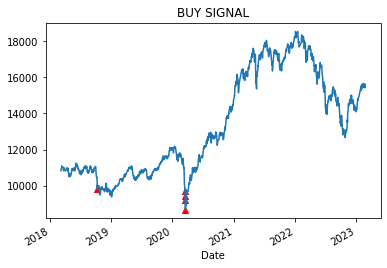

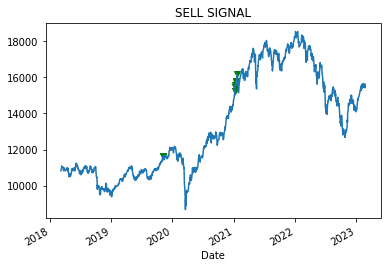

買入時間: 2018-08-14 00:00:00
買入價格: 10824.23046875
賣出時間: 2018-09-11 00:00:00
賣出價格: 10752.2998046875
獲利: -6617.62109375
買入時間: 2020-01-08 00:00:00
買入價格: 11817.099609375
賣出時間: 2020-01-14 00:00:00
賣出價格: 12179.8095703125
獲利: 30467.63671875


In [11]:
signals = process(df)
capital = 1000000  # 初始資本
hold = False  # 是否持有股票
entry_price = 0  # 進場價格
entry_idx = 0  # 進場時間點
exit_price = 0  # 出場價格
exit_idx = 0  # 出場時間點
t = 20
lb = 0.97
ub = 1.03
capital_history = []
for i, signal in enumerate(signals):
    if signal == 1 and not hold:  # 進場買入
        hold = True
        entry_price = df.iloc[i]['Close']
        entry_idx = i
    elif signal == 2 and hold:  # 出場賣出
        hold = False
        exit_price = df.iloc[i]['Close']
        exit_idx = i
        # 計算交易結果
        shares = capital // entry_price
        profit = shares * (exit_price - entry_price)
        capital += profit
        print('買入時間:', df.index[entry_idx])
        print('買入價格:', entry_price)
        print('賣出時間:', df.index[exit_idx])
        print('賣出價格:', exit_price)
        print('獲利:', profit)
    elif hold and (i - entry_idx >= t or df.iloc[i]['Close'] <= entry_price * lb or df.iloc[i]['Close'] >= entry_price * ub):  # 到達出場條件
        hold = False
        exit_price = df.iloc[i]['Close']
        exit_idx = i
        # 計算交易結果
        shares = capital // entry_price
        profit = shares * (exit_price - entry_price)
        capital += profit
        print('買入時間:', df.index[entry_idx])
        print('買入價格:', entry_price)
        print('賣出時間:', df.index[exit_idx])
        print('賣出價格:', exit_price)
        print('獲利:', profit)
    capital_history.append(capital)

最終報酬率:+2.385001562500011%
最大虧損:-0.661762109374997%


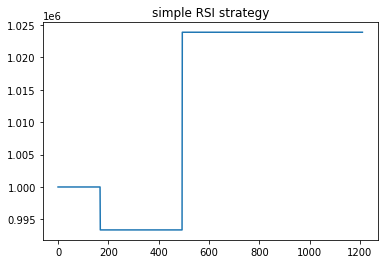

In [12]:
plt.plot(capital_history)
plt.title('simple RSI strategy')
print(f"最終報酬率:+{(capital_history[-1]/capital_history[0]-1)*100}%")
print(f"最大虧損:{-(1-min(capital_history)/capital_history[0])*100}%")